## Поиск источника девиаций по данным Splunk

In [1]:
import splunklib
import splunklib.client as client
import splunklib.results as results

import datetime as dt
from time import sleep

import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import matplotlib as mpl
import matplotlib.pyplot as plt

import lowess as lo

#%matplotlib notebook

In [2]:
#Подключение к Splunk

HOST = "splunk-search01.roamability.com"
PORT = 8089
USERNAME = "pavel"
PASSWORD = "O777ver7k1"
# Create a Service instance and log in 
service = client.connect(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD)

In [3]:
#Создаем необходимые процедуры

log_level = 0

def outLog(message, level=1):
    if(level <= log_level):
        print (message)
        sys.stdout.flush()

def FormatSplunkEngineDate(dt): return dt.strftime("%Y-%m-%dT%H:%M:%S")

In [98]:
#Указываем время, запрос и запускаем запрос

dateFrom = dt.datetime.strptime('2018-07-02T00:00:00', '%Y-%m-%dT%H:%M:%S')
dateTo = dt.datetime.strptime('2018-07-09T00:00:00', '%Y-%m-%dT%H:%M:%S')
searchquery_export =\
'''
search index=sdr (4250196* OR 26006*) PROTOCOL=S6a ANS_RES_CODE=2001
| eval CODE_TEMP=case(isnotnull(ANS_RES_CODE),ANS_RES_CODE,isnull(ANS_RES_CODE), ANS_EXP_RES_CODE, isnull(ANS_EXP_RES_CODE), EXP_RES_CODE, isnull(EXP_RES_CODE), RES_CODE)
| eval CODE=if(isnotnull(CODE_TEMP), CODE_TEMP, "PUR_NOR") | eval CUSTOMER=coalesce(THIRD_PARTY,MVNO)
| Timechart span=15m count by CUSTOMER  | table * | sort by _time
'''

In [99]:
## Исправленный вариант обращения к Splunk на основе:
#http://docs.splunk.com/DocumentationStatic/PythonSDK/1.6.3/client.html#splunklib.client.Job.results
#Кол-во записей в результате на основе:
#https://answers.splunk.com/answers/237043/how-to-submit-a-splunk-python-sdk-query-with-a-res.html

bEchoTime = False

sfrom = dateFrom if  bEchoTime else FormatSplunkEngineDate(dateFrom) 
sto = dateTo if  bEchoTime else FormatSplunkEngineDate(dateTo)

kwargs_export = {"earliest_time": sfrom,
                 "latest_time":sto ,
                 "search_mode": "normal",
                 #"output_mode":"JSON",
                 #"rf" : fields,
                 "supports_multivalues":True
                 }

kwargs_paginate = {"count": 1000  # Get sets of count results at a time
                   ,"offset": 0  # Start at result 0
                  }

job = service.jobs.create(searchquery_export, **kwargs_export)

while not job.is_done():
    sleep(.2)

rr = results.ResultsReader(job.results(**kwargs_paginate))

outputResult = list()
i=0

for result in rr:
            if isinstance(result, dict):
                outputResult.append(result)
assert rr.is_preview == False

# Получаем исходные данные для анализа с датой и временем в индексе

df_source=DataFrame(outputResult,dtype='int64')
df_source['rep_date']=pd.to_datetime(df_source['_time'])
df_source.drop(['_time','_span'],axis=1,inplace=True)
df_source=df_source.set_index('rep_date')

# Получаем исходные данные для анализа с временем в индексе

df_source_time=DataFrame(outputResult,dtype='int64')
df_source_time['rep_time']=pd.to_datetime(df_source_time['_time'])
df_source_time['rep_time']=df_source_time['rep_time'].apply(lambda x: dt.datetime.strptime(x.strftime('%H:%M'),'%H:%M'))
df_source_time.drop(['_time','_span'],axis=1,inplace=True)
df_source_time=df_source_time.set_index('rep_time')

print("Найдено записей:\n{}\n".format(len(df_source.index)))
display(df_source.tail())
display(df_source_time.tail())

Найдено записей:
672



,C9,MB,Mondicon,NAKA,Nextel,OTHER,PuertoSeguro,Roamability,Telzar,Tinklabs,WMB_Combined
rep_date,,,,,,,,,,,
2018-07-08 20:45:00,1594,586,212,4458,12,5,362,299,5687,542,0
2018-07-08 21:00:00,981,334,333,3948,29,0,290,239,4748,521,0
2018-07-08 21:15:00,729,367,305,3606,9,0,335,268,4164,432,0
2018-07-08 21:30:00,663,418,287,3398,9,1,320,248,4015,494,0
2018-07-08 21:45:00,676,173,278,2817,9,0,317,228,3738,455,0


,C9,MB,Mondicon,NAKA,Nextel,OTHER,PuertoSeguro,Roamability,Telzar,Tinklabs,WMB_Combined
rep_time,,,,,,,,,,,
1900-01-01 20:45:00,1594,586,212,4458,12,5,362,299,5687,542,0
1900-01-01 21:00:00,981,334,333,3948,29,0,290,239,4748,521,0
1900-01-01 21:15:00,729,367,305,3606,9,0,335,268,4164,432,0
1900-01-01 21:30:00,663,418,287,3398,9,1,320,248,4015,494,0
1900-01-01 21:45:00,676,173,278,2817,9,0,317,228,3738,455,0


['C9', 'MB', 'Mondicon', 'NAKA', 'Nextel', 'OTHER', 'PuertoSeguro', 'Roamability', 'Telzar', 'Tinklabs', 'WMB_Combined']


,C9,C9_lo,C9_std_first_step,C9_adj,C9_adj_first_step,C9_std
rep_time,,,,,,
1900-01-01,328.0,479.112243,124.702446,433.368990,328.0,51.852676
1900-01-01,451.0,476.071977,130.980024,431.514506,451.0,46.739348
1900-01-01,396.0,472.561490,123.890889,429.769076,396.0,42.900771
1900-01-01,661.0,469.567266,117.771495,427.936672,443.0,39.949745
1900-01-01,443.0,466.657991,104.760952,425.782045,443.0,29.007388


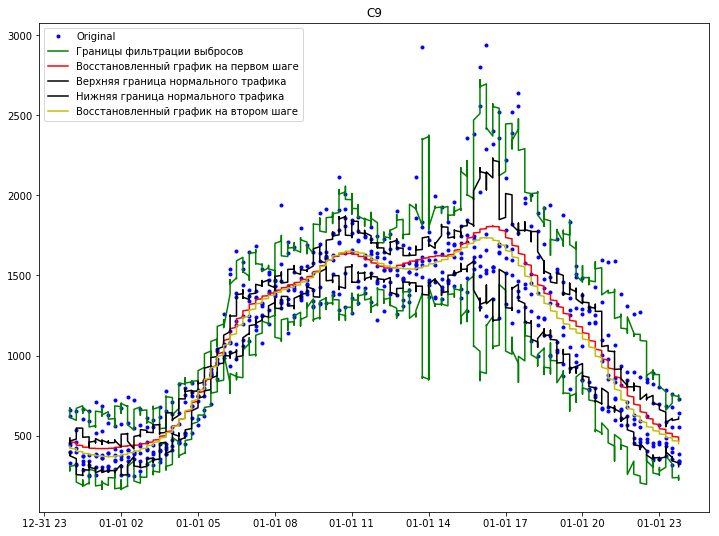

,MB,MB_lo,MB_std_first_step,MB_adj,MB_adj_first_step,MB_std
rep_time,,,,,,
1900-01-01,256.0,198.414702,88.787386,196.887029,256.0,88.787386
1900-01-01,314.0,197.260815,79.840883,195.343600,314.0,79.840883
1900-01-01,156.0,196.058715,73.751513,193.897747,156.0,73.751513
1900-01-01,92.0,194.708266,71.759395,192.413672,92.0,71.759395
1900-01-01,156.0,193.559693,67.955737,191.214133,156.0,67.955737


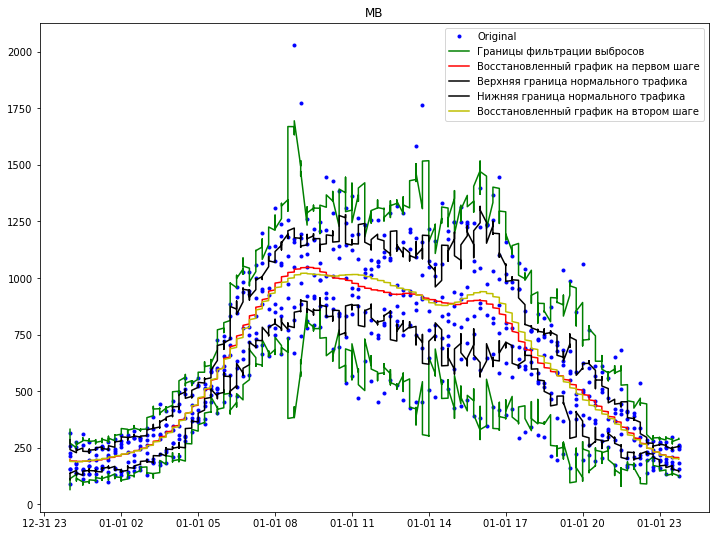

,Mondicon,Mondicon_lo,Mondicon_std_first_step,Mondicon_adj,Mondicon_adj_first_step,Mondicon_std
rep_time,,,,,,
1900-01-01,125.0,123.183449,98.871128,130.817049,125.0,98.871128
1900-01-01,115.0,124.597723,115.766575,130.842002,115.0,115.766575
1900-01-01,10.0,125.692014,105.821953,130.371407,10.0,105.821953
1900-01-01,251.0,126.867920,107.855641,129.910167,251.0,107.855641
1900-01-01,14.0,128.244603,114.615428,129.649416,14.0,114.615428


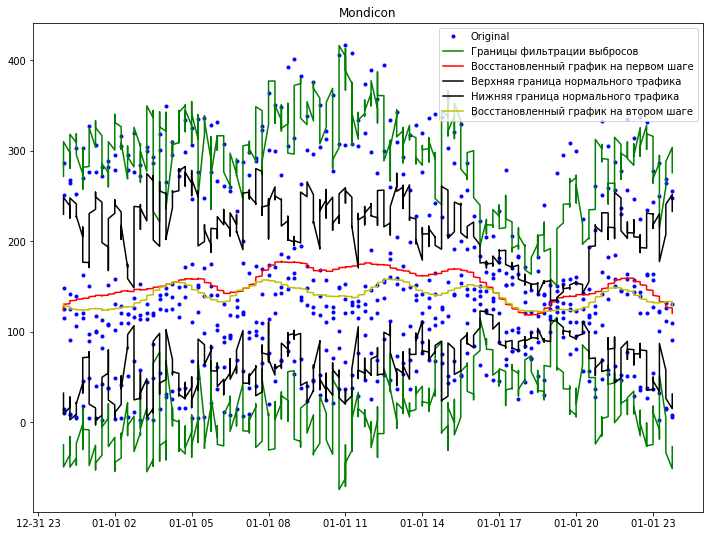

,NAKA,NAKA_lo,NAKA_std_first_step,NAKA_adj,NAKA_adj_first_step,NAKA_std
rep_time,,,,,,
1900-01-01,2127.0,2144.912003,342.390566,2057.435557,2127.0,109.310109
1900-01-01,2062.0,2137.782279,306.627896,2047.412601,2062.0,120.803008
1900-01-01,1846.0,2129.735229,330.046389,2037.858835,1846.0,171.982280
1900-01-01,2754.0,2123.285797,323.399107,2029.779062,2073.0,174.549215
1900-01-01,2073.0,2118.312456,323.017884,2023.245550,2073.0,172.437152


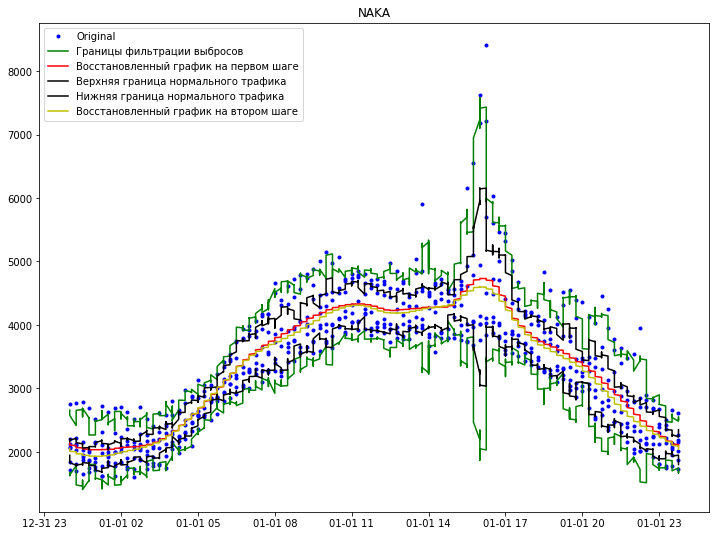

,Nextel,Nextel_lo,Nextel_std_first_step,Nextel_adj,Nextel_adj_first_step,Nextel_std
rep_time,,,,,,
1900-01-01,16.0,9.756742,4.549725,10.358718,16.0,4.549725
1900-01-01,8.0,9.695647,4.273952,10.237415,8.0,4.273952
1900-01-01,13.0,9.616649,5.094348,10.111227,13.0,4.281744
1900-01-01,5.0,9.523148,4.869732,9.975432,5.0,4.208834
1900-01-01,14.0,9.426234,4.026697,9.832435,14.0,3.412163


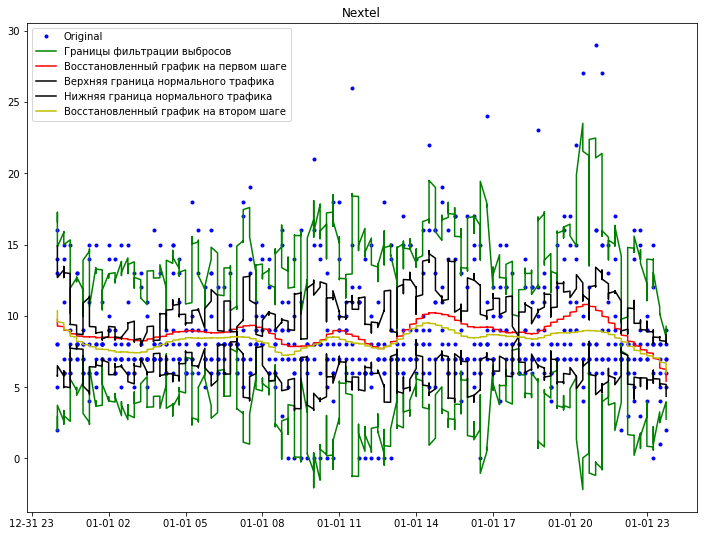

,OTHER,OTHER_lo,OTHER_std_first_step,OTHER_adj,OTHER_adj_first_step,OTHER_std
rep_time,,,,,,
1900-01-01,1.0,1.017180,2.509980,0.613430,1.0,0.547723
1900-01-01,0.0,1.075886,2.338090,0.640908,0.0,0.516398
1900-01-01,6.0,1.135000,2.193063,0.662573,0.0,0.487950
1900-01-01,0.0,1.191070,2.070197,0.678772,0.0,0.462910
1900-01-01,1.0,1.241925,2.100170,0.689939,1.0,0.353553


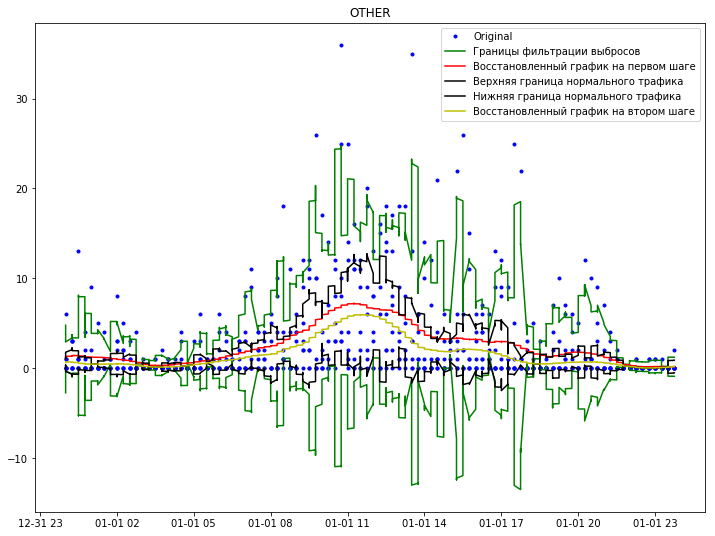

,PuertoSeguro,PuertoSeguro_lo,PuertoSeguro_std_first_step,PuertoSeguro_adj,PuertoSeguro_adj_first_step,PuertoSeguro_std
rep_time,,,,,,
1900-01-01,261.0,341.757187,76.774345,323.128312,261.0,76.774345
1900-01-01,297.0,339.696617,69.522418,321.304267,297.0,69.522418
1900-01-01,399.0,337.995386,63.470278,320.375185,399.0,63.470278
1900-01-01,260.0,336.298159,64.593095,319.809670,260.0,64.593095
1900-01-01,420.0,334.246282,63.501265,319.118709,420.0,62.721607


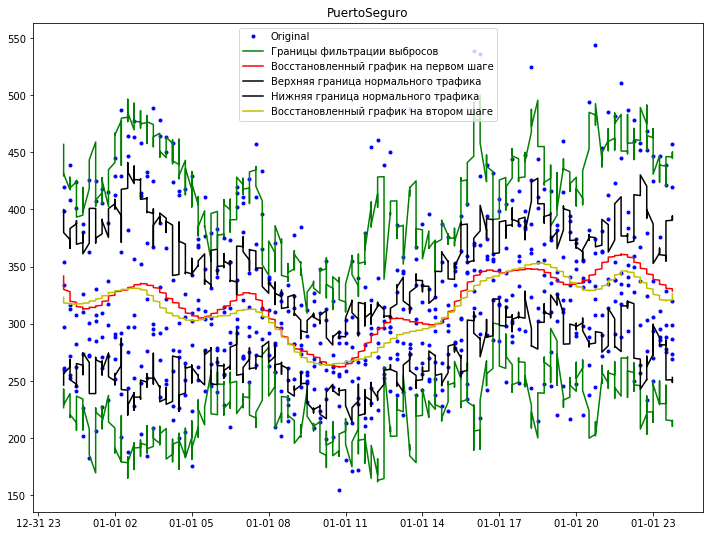

,Roamability,Roamability_lo,Roamability_std_first_step,Roamability_adj,Roamability_adj_first_step,Roamability_std
rep_time,,,,,,
1900-01-01,49.0,186.609031,125.386203,133.519830,49.0,67.275553
1900-01-01,218.0,187.606703,117.540489,134.974647,218.0,63.035440
1900-01-01,376.0,188.469773,109.095851,136.428984,175.0,66.027411
1900-01-01,175.0,189.012535,141.604013,137.695154,175.0,63.127988
1900-01-01,103.0,188.745307,133.650664,138.858173,103.0,53.722667


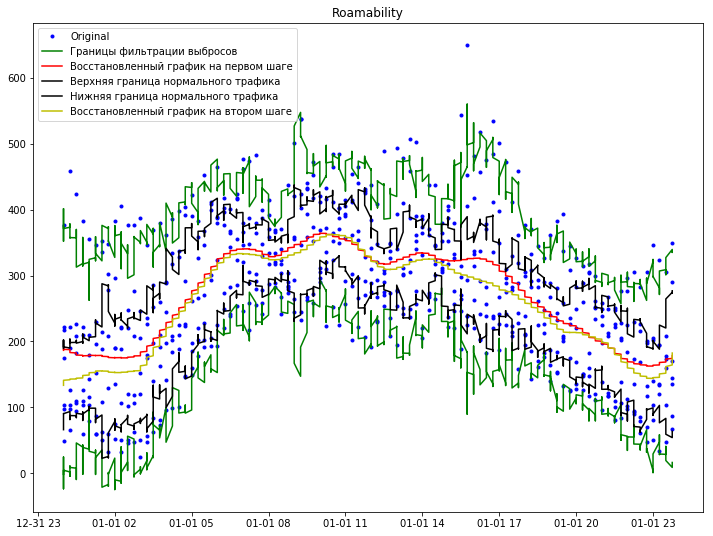

,Telzar,Telzar_lo,Telzar_std_first_step,Telzar_adj,Telzar_adj_first_step,Telzar_std
rep_time,,,,,,
1900-01-01,3427.0,3697.026997,264.517485,3749.977615,3427.0,264.517485
1900-01-01,4125.0,3688.392117,293.152293,3734.851571,4125.0,238.724946
1900-01-01,3554.0,3678.080289,273.445825,3719.126393,3554.0,219.305506
1900-01-01,3657.0,3665.914121,253.696528,3702.416659,3657.0,207.299645
1900-01-01,3642.0,3652.534882,241.853520,3685.199275,3642.0,185.077542


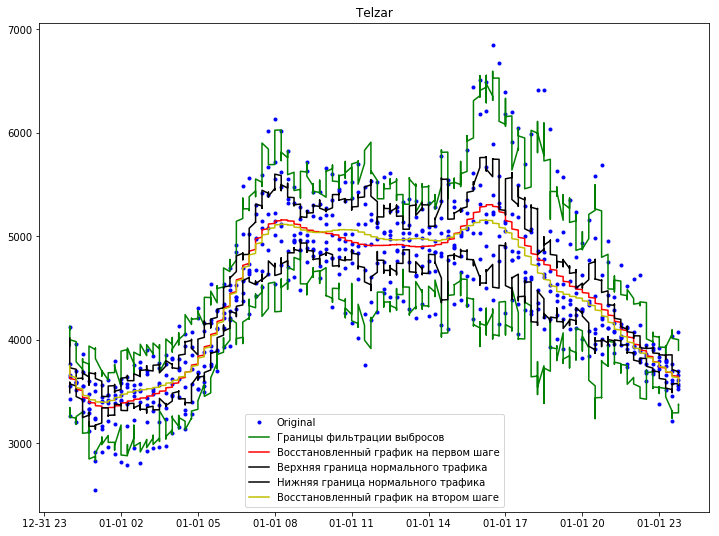

,Tinklabs,Tinklabs_lo,Tinklabs_std_first_step,Tinklabs_adj,Tinklabs_adj_first_step,Tinklabs_std
rep_time,,,,,,
1900-01-01,492.0,344.068320,114.940419,351.480554,492.0,67.403264
1900-01-01,303.0,343.118769,108.322974,349.128821,303.0,78.774996
1900-01-01,417.0,342.741688,99.054579,347.153409,417.0,72.250556
1900-01-01,194.0,342.354749,92.592714,345.911884,397.0,66.938671
1900-01-01,397.0,342.100042,76.664389,345.338397,397.0,50.025529


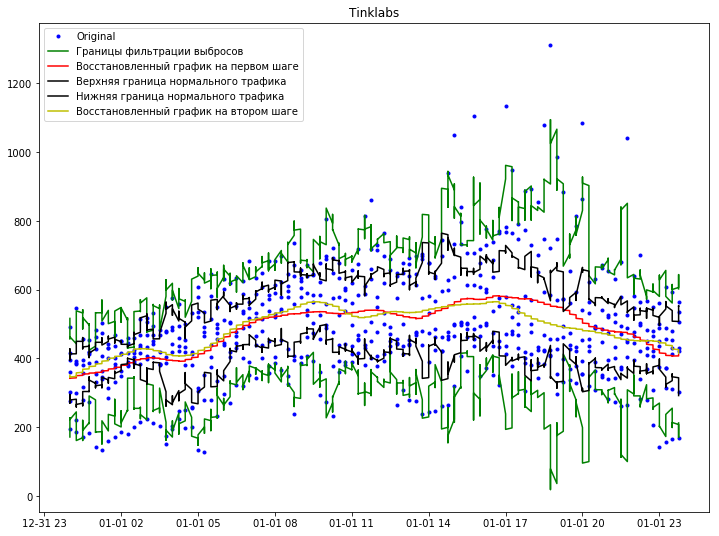

,WMB_Combined,WMB_Combined_lo,WMB_Combined_std_first_step,WMB_Combined_adj,WMB_Combined_adj_first_step,WMB_Combined_std
rep_time,,,,,,
1900-01-01,0.0,4.254731,5.215362,3.030116,0.0,4.098780
1900-01-01,0.0,4.186398,5.125102,3.023278,0.0,4.082483
1900-01-01,12.0,4.124133,4.956958,3.021001,8.0,3.976119
1900-01-01,8.0,4.086446,4.611709,3.041535,8.0,3.739270
1900-01-01,6.0,4.031950,4.764077,3.049406,6.0,3.739270


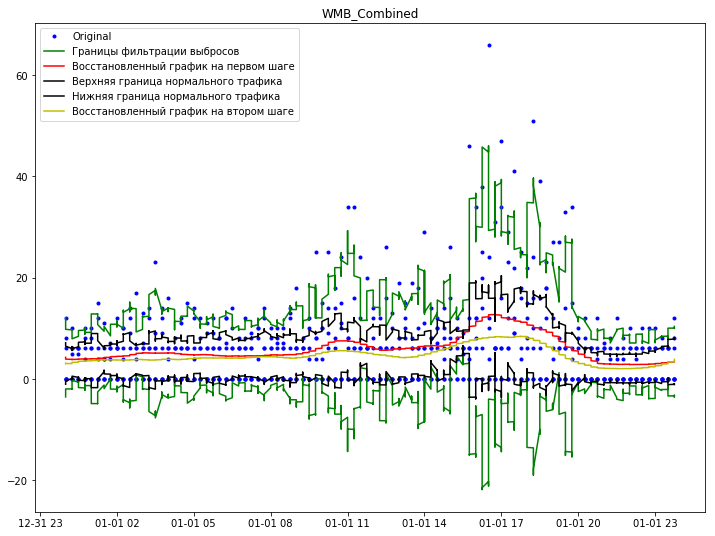

In [101]:
#Задаем необходимые переменные
#Window для расчета скользящего стандартного отклонения берем как, например, 1/12 от периода

v_window=8 #скользящее окно
k_out=1.5 #Коэффициент для умножения на std для расчета границ фильтрации выборосов

i=df_source_time.index.shape[0]
x=np.linspace(-10,10,i)

#Вспомогательная функция для отсечения значений, выходящих за границы фильтрации выборосов

def f_out(x):
    name=x.index[0]
    if x[name] > x[name+'_lo']+k_out*x[name+'_std_first_step']:
        x[name+'_adj']=np.nan
    elif x[name] < x[name+'_lo']-k_out*x[name+'_std_first_step']:
        x[name+'_adj']=np.nan
    else:
        x[name+'_adj']=x[name]
    return x

#Функция для обработки данных.
#На вход функции подается объект Series из исходных данных.
#На выходе получаем данные с отсеченными выбросами ['lo'] и со стандартным отколонением для обработанных данных ['std'].

def f_low(df_x):
    df_res=DataFrame(df_x)
    name=df_res.columns[0]
    i=df_x.index.shape[0]
    x=np.linspace(-10,10,i)
    df_res[name+'_lo'] = lo.lowess(x, df_x.values, x)
    df_res[name+'_std_first_step'] = df_x.rolling(window=v_window,min_periods=0).std().fillna(method='bfill').shift(-int(v_window/2))
    df_res=df_res.apply(f_out,axis=1)
    df_res[name+'_adj_first_step']=df_res[name+'_adj'].fillna(method='bfill')
    df_res[name+'_adj'] = lo.lowess(x, np.array(df_res[name+'_adj_first_step']), x)
    df_res[name+'_std'] = df_res[name+'_adj_first_step'].rolling(window=v_window,min_periods=0).std().fillna(method='bfill').shift(-int(v_window/2))
    return df_res

l=list(df_source_time.columns)
print(l)

for name in l:

    df=f_low(df_source_time[name].sort_index(axis=0))
    display(df.head())

    fig,ax = plt.subplots(1,figsize=(12,9))
    ax.plot(df[name],'b.',label='Original') #исходный график
    ax.plot(df[name+'_lo']+k_out*df[name+'_std_first_step'],'g',label='Границы фильтрации выбросов') #Верхняя граница для фильтрации выборосов
    ax.plot(df[name+'_lo']-k_out*df[name+'_std_first_step'],'g',label='Границы фильтрации выбросов') #Нижняя граница для фильтрации выборосов
    ax.plot(df[name+'_lo'],'r', label='Восстановленный график на первом шаге') #Восстановленный график методом lowess на первом шаге
    ax.plot(df[name+'_adj']+df[name+'_std'],'k', label='Верхняя граница нормального трафика') #Верхняя граница нормального трафика
    ax.plot(df[name+'_adj']-df[name+'_std'],'k', label='Нижняя граница нормального трафика') #Нижняя граница нормального трафика
    ax.plot(df[name+'_adj'],'y', label='Восстановленный график на втором шаге') #Восстановленный график методом lowess на втором шаге
    ax.set_title(name)
    plt.legend()
    plt.show()

Замечание для дальнейшей работы.
Если брать несколько периодов, то lowess сглаживает вершины периодов и хорошего усреднения трафика не получается.
Нужно брать один (или два) период и накладывать периоды друг на друга.